## Analysis

In [1]:
projectPath <- c("/data/pinello/PROJECTS/2019_03_scATAC/Methods/scABC/")

In [2]:
options(stringsAsFactors = FALSE)
library(GenomicRanges)
library(scABC)
library(Rsamtools)
library(data.table)
library(dplyr)
library(tidyverse)

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Loading required package: S4Ve

Modified functions to ignore unmapped reads [by adding isUnmappedQuery = FALSE to ScanBamParam] instead of having to remove those from the BAM files:

In [3]:
bam2gr <- function(bamfile, PAIRED = FALSE) {
  if (PAIRED) {
    scanned = scanBam(bamfile, param = ScanBamParam(flag =scanBamFlag(isMinusStrand = FALSE,
                                                                      isUnmappedQuery = FALSE,
                                                                      isProperPair = TRUE),
                                                    what = c("rname", "pos", "isize")))[[1]]
    out = GRanges(seqnames = scanned$rname, IRanges(start = scanned$pos, width = scanned$isize))
  } else {
    scanned = scanBam(bamfile, param = ScanBamParam(flag =scanBamFlag(isUnmappedQuery = FALSE),
                                                    what = c("rname", "pos", "strand", "qwidth")))[[1]]
    out = GRanges(seqnames = scanned$rname,
                  IRanges(start = ifelse(scanned$strand == "-", scanned$pos + scanned$qwidth - 1, scanned$pos),
                          width = scanned$qwidth))
  }
  return(out)
}

In [4]:
getCountsByReadGroup <- function(bamfile, peaks, RGtag, tags = NULL, PAIRED = FALSE, VERBOSE = FALSE){
  scanned <- Rsamtools::scanBam(bamfile,
                     param = Rsamtools::ScanBamParam(flag =scanBamFlag(isUnmappedQuery = FALSE),
                                                     what = c("rname", "pos", "strand", "qwidth"),
                                                     tag = RGtag))[[1]]
  if(is.null(tags)){
    RGtags = unique(unlist(scanned$tag[RGtag]))
  }
  counts_mat = Matrix::Matrix(0, nrow = length(peaks), ncol = length(tags), sparse = TRUE)
  for(i in 1:length(tags)){
    tag = tags[i]
    if(VERBOSE){
      message("Processing tag ", tag)
    }
    match_RG <- which(scanned$tag[[RGtag]] == tag)
    # convert bamfiles to Genomic Ranges
    bam.gr = GenomicRanges::GRanges(seqnames = scanned$rname[match_RG],
                                    IRanges::IRanges(start = sapply(match_RG, function(i) ifelse(scanned$strand[i] == "-",
                                                                         scanned$pos[i] + scanned$qwidth[i] - 1,
                                                                         scanned$pos[i])),
                             width = scanned$qwidth[match_RG]))
    counts_mat[,i] = GenomicRanges::countOverlaps(peaks, bam.gr, type = "any", ignore.strand = TRUE)
  }
 # counts = do.call(cbind, lapply(RGtags, function(x) getTagCounts(x, bamfile, peaks)))
  colnames(counts_mat) = tags
  return(counts_mat)
}

In [5]:
peaks2GRanges <- function(peaks, upstream = 0, downstream = 0){
  peaks.gr = with(peaks, GenomicRanges::GRanges(chrom, IRanges::IRanges(sapply(start, function(x) max(0, x - upstream)), end + downstream), 
                                                                               id = name))#, pVal = pValue))
}

# peaks should be in GenomicRanges
get_counts_from_bam <- function(bamfile, peaks){
  param = Rsamtools::ScanBamParam(flag =scanBamFlag(isUnmappedQuery = FALSE), 
                                  which = peaks, 
                                  what = c("rname", "pos", "strand", "qwidth"))
  counts = Rsamtools::countBam(bamfile, param = param,
                               flag = Rsamtools::scanBamFlag(isDuplicate = FALSE,
                                                             isUnmappedQuery = FALSE))
  return(counts[,c("space", "start", "end", "file", "records")])
}

In [6]:
getCountsMatrix <- function(bamfiles, peaks, PAIRED = FALSE,
                            byReadGroup = FALSE, 
                            RGtag = 'RG',
                            tags2include = NULL, 
                            VERBOSE = FALSE){
  peaks.gr = peaks2GRanges(peaks)
  if(VERBOSE){
    message("beginning reading in counts\n")
  }
  if(byReadGroup){
    if(VERBOSE){
      message("getting counts by read group\n")
      message("read group tag = ", RGtag, "\n")
    }
    stopifnot(length(bamfiles) == 1)
    counts_mat = getCountsByReadGroup(bamfiles, peaks.gr, RGtag = RGtag, 
                                      tags = tags2include);
    rownames(counts_mat) = peaks$name
  }
  else{
    nCells = length(bamfiles)
    counts_mat = matrix(nrow = length(peaks.gr), ncol = nCells)
    for(i in 1:nCells){
      if(VERBOSE){
        message("Processing file ", bamfiles[i])
      }
      # convert bamfiles to Genomic Ranges
      bam.gr = bam2gr(bamfiles[i], PAIRED = PAIRED)
      counts_mat[,i] = countOverlaps(peaks.gr, bam.gr, type = "any", ignore.strand = TRUE)
    }
    colnames(counts_mat) = bamfiles
    rownames(counts_mat) = peaks$name
    #counts_info = data.frame(chrom = counts_list[[1]]$space, start = counts_list[[1]]$start, end = counts_list[[1]]$end, name = peaks$id, pValue = peaks$pVal)
  }
  peaks = peaks[,c("chrom", "start", "end", "name")]#, "pValue")]
  return(list(peaks = peaks, ForeGroundMatrix = Matrix::Matrix(counts_mat, sparse = TRUE)))
}

In [7]:
sort_peaks <- function(peaks){
  return(peaks[order(peaks$chrom, peaks$start), ])
}

In [8]:
selectPeaks <- function(filename, thresh = 2){
  peaks = read.table(file = filename, header = FALSE, sep = "\t",
                     stringsAsFactors = FALSE);
  if(dim(peaks)[2] == 15){
    # gapped peaks
    column_names = c("chrom", "start", "end", "name", "score", "strand",
                     "thickStart", "thickEnd", "itemRgb", "blockCount", "blockSizes",
                     "blockStarts", "signalValue", "pValue", "qValue");
    colnames(peaks) = column_names
    wanted_peaks = which(peaks$pValue > thresh); # pValue is -log10(p), p < 0.1 => pValue > 2
    peaks = sort_peaks(peaks[wanted_peaks, ])
  }
  if(dim(peaks)[2] == 10){
    # narrow peaks
    column_names = c("chrom", "start", "end", "name", "score", "strand",
                     "foldChange", "pValue", "qValue", "summit2PeakDist")
    colnames(peaks) = column_names
    wanted_peaks = which(peaks$pValue > thresh); # pValue is -log10(p), p < 0.1 => pValue > 2
    peaks = sort_peaks(peaks[wanted_peaks, ])
  }
  
  # mine  
  if(dim(peaks)[2] == 3){
    # gapped peaks
    column_names = c("chrom", "start", "end");
    colnames(peaks) = column_names
    peaks = sort_peaks(peaks)
  }
  return(peaks)
}

In [9]:
getBackground <- function(bamfiles, peaks, upstream = 500000,
                          downstream = 500000, byReadGroup = FALSE,
                          VERBOSE = FALSE, PAIRED = FALSE){
  nCells = length(bamfiles)
  background_peaks.gr = peaks2GRanges(peaks, upstream, downstream)
  if(byReadGroup){
    counts_mat = getCountsByReadGroup2(bamfile, background_peaks.gr);
    rownames(counts_mat) = peaks$name
  }
  else{
    counts_mat = matrix(nrow = length(background_peaks.gr), ncol = nCells)
    for(i in 1:nCells){
      if(VERBOSE){
        message("Processing file ", bamfiles[i])
      }
      # convert bamfiles to Genomic Ranges
      bam.gr = bam2gr(bamfiles[i], PAIRED = PAIRED)
      counts_mat[,i] = countOverlaps(background_peaks.gr, bam.gr, type = "any", ignore.strand = TRUE)
    }
    colnames(counts_mat) = bamfiles
    rownames(counts_mat) = peaks$name
    #counts_info = data.frame(chrom = counts_list[[1]]$space, start = counts_list[[1]]$start, end = counts_list[[1]]$end, name = peaks$id, pValue = peaks$pVal)
  }
  peaks = peaks[,c("chrom", "start", "end", "name")]#, "pValue")]
  return(list(peaks = peaks, BackGroundMatrix = Matrix::Matrix(counts_mat, sparse = TRUE)))
}

In [10]:
# loading input 1: single-cell BAM files
start_time <- Sys.time()
bamfiles <- list.files("/data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/sc-bams/", 
                       pattern = "*.bam", full.names = TRUE)
end_time <- Sys.time()
print(end_time - start_time)
#Time difference of 0.03876805 secs

Time difference of 0.03687716 secs


In [11]:
length(bamfiles)

[1] 2034

In [12]:
# peaks <- read.delim("/data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/peaks/merged_sc-bams/combined.sorted.merged.bed",
#                  header = F, sep = "\t") 

In [13]:
# write.table(peaks[,1:3], "/data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/peaks/sara_test.bed",
#           col.names = F, row.names = F, sep = "\t", quote = F)

In [14]:
# loading input 2: peaks file
# peaks are filtered as: pValue is -log10(p), p < 0.1 => pValue > 2
start_time <- Sys.time()
peakfile <- selectPeaks("/data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/peaks/merged_sc-bams/combined.sorted.merged.bed")
end_time <- Sys.time()
print(end_time - start_time)
#Time difference of 1.876538 secs

Time difference of 0.371927 secs


In [15]:
peakfile$name <- paste("Peak", peakfile$chrom, peakfile$start, peakfile$end, sep = "_")

In [16]:
dim(peakfile)

[1] 237450      4

In [17]:
# computing the foreground matrix 
start_time <- Sys.time()
ForeGround <- getCountsMatrix(bamfiles, peakfile, PAIRED = FALSE, byReadGroup = FALSE) 
end_time <- Sys.time()
print(end_time - start_time)
#Time difference of 22.62651 mins

Time difference of 15.31861 mins


In [18]:
dim(ForeGround$peaks)

[1] 237450      4

In [19]:
# they advise to filter out low-represented peaks 
# keep peaks with aminimum of 2 reads in at least 10 cells
start_time <- Sys.time()
PeaksFiltered <- filterPeaks(ForeGround$ForeGroundMatrix, peakfile, nreads_thresh = 2, ncells_thresh = 10)
end_time <- Sys.time()
print(end_time - start_time)
#Time difference of 3.484232 secs

Time difference of 2.611856 secs


In [20]:
dim(PeaksFiltered$peaks)

[1] 133210      4

In [21]:
# computing the background matrix
start_time <- Sys.time()
BackGround <- getBackground(bamfiles, PeaksFiltered$peaks, 
                           upstream = 5e+05, downstream = 5e+05,
                           PAIRED = FALSE, byReadGroup = FALSE)
end_time <- Sys.time()
print(end_time - start_time)
#Time difference of 21.61112 hours

Time difference of 16.02726 mins


In [22]:
library(Matrix)


Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

The following object is masked from ‘package:S4Vectors’:

    expand



In [23]:
thr = 0.01

In [24]:
## new: additional peak filtering
x = as.matrix(PeaksFiltered$ForeGroundMatrix)
binary_mat = as.matrix((x > 0) + 0)
binary_mat = Matrix(binary_mat, sparse = TRUE)     
num_cells_ncounted = Matrix::rowSums(binary_mat)
ncounts = x[num_cells_ncounted >= dim(x)[2]*thr,] 
# new_counts = colSums(ncounts)
# ncounts = ncounts[,new_counts >= quantile(new_counts,probs=0.1)]
ncounts = ncounts[rowSums(ncounts) > 0,]

In [25]:
dim(ncounts)

[1] 102239   2034

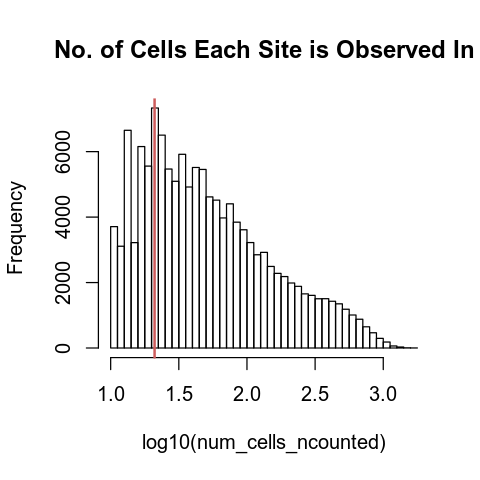

In [26]:
options(repr.plot.width=4, repr.plot.height=4)
hist(log10(num_cells_ncounted),main="No. of Cells Each Site is Observed In",breaks=50)
abline(v=log10(min(num_cells_ncounted[num_cells_ncounted >= dim(x)[2]*thr])),lwd=2,col="indianred")
# hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
# abline(v=log10(quantile(new_counts,probs=0.1)),lwd=2,col="indianred")

In [27]:
# computing weights and transforming the features matrix
start_time <- Sys.time()
fg.mat <- ncounts #previously: as.matrix(PeaksFiltered$ForeGroundMatrix)
bg.mat <- as.matrix(BackGround$BackGroundMatrix)
# need to filter the background to the same peaks and cells as the foreground matrix
idx.rows <- which(rownames(bg.mat) %in% rownames(fg.mat))
idx.cols <- which(colnames(bg.mat) %in% colnames(fg.mat))
bg.mat <- as.matrix(BackGround$BackGroundMatrix)[idx.rows,idx.cols]
weights <- apply(bg.mat, 2, median)
c <- min(8, median(weights))
lambda = 0.1
z <- 1/(1 + exp(-(weights - c)/(c*lambda)))
# this is the features matrix of interest
fg.mat.weight <- sapply(1:length(z), function(x) (fg.mat[,x] * z[x]))
end_time <- Sys.time()
print(end_time - start_time)
#Time difference of 46.89922 secs (previous run 37.62924 mins)

Time difference of 27.56604 secs


In [28]:
dim(fg.mat.weight)
# 675274 2034 
# new: 139526 2034 

[1] 102239   2034

In [29]:
head(fg.mat.weight)

Peak_chr1_10413_10625,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Peak_chr1_13380_13624,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Peak_chr1_16145_16354,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Peak_chr1_96388_96812,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,2,0,0
Peak_chr1_115650_115812,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Peak_chr1_237625_237888,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [31]:
# cell names must match those in 
# /data/pinello/PROJECTS/2019_03_scATAC/Datasets/Buenrostro_2018/metadata/celltype_FACS_corrected.tsv
start_time <- Sys.time()
colnames(fg.mat.weight) <- sapply(strsplit(sapply(strsplit(colnames(bg.mat),"\\/"),'[',i=10),"\\.st"),'[',i=1)
write.table(fg.mat.weight, 
           "/data/pinello/PROJECTS/2019_03_scATAC/FeatureMatrix/FM_scABC_buenrostro2018.tsv", 
            col.names = T, row.names = T, sep = "\t", quote = F)
end_time <- Sys.time()
print(end_time - start_time)
#Time difference of 3.56756 mins

Time difference of 2.392638 mins
